#### 참고 : tensorflow.keras 공식 문서 (Official API Docs) @ https://www.tensorflow.org/api_docs/python/tf/keras

<br>

## 1. Data loading & preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
titanic_df = pd.read_csv("titanic.csv")
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
del titanic_df['Cabin'] # 너무 많은 결측치가 존재
del titanic_df['PassengerId'] # Passenger 번호는 큰 의미를 갖고있지 않은 일련번호
del titanic_df['Ticket'] # ticket 번호에서 패턴이 확인되지 않음


titanic_df['Title'] = titanic_df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
del titanic_df['Name'] # 호칭만 남김

rare_title = []
for title in set(titanic_df['Title']):
    if list(titanic_df['Title']).count(title) < 10:
        rare_title.append(title)

titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss') # Mademoiselle
titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss') 
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs') # Madame
titanic_df['Title'] = titanic_df['Title'].replace(rare_title, 'Rare')

title_mapping = {"Master":1, "Miss":2, "Mr":3, "Mrs":4, "Rare":5 }
titanic_df['Title'] = titanic_df['Title'].map(title_mapping)
titanic_df['Title'] = titanic_df['Title'].fillna(0)
titanic_df['Title'].astype(int)


sex_mapping = {"male": 0 , "female":1} 
titanic_df['Sex'] = titanic_df['Sex'].map(sex_mapping)


titanic_df['Embarked'] = titanic_df['Embarked'].fillna('S')
mapping_data ={"S":0, "Q":1, "C":2}
titanic_df["Embarked"] = titanic_df["Embarked"].map(mapping_data)


titanic_df.loc[ titanic_df['Fare'] <= 102, 'Fare'] = 0
titanic_df.loc[(titanic_df['Fare'] > 102) & (titanic_df['Fare'] <= 204), 'Fare'] = 1
titanic_df.loc[(titanic_df['Fare'] > 204) & (titanic_df['Fare'] <= 307), 'Fare'] = 2
titanic_df.loc[ titanic_df['Fare'] > 307, 'Fare'] = 4


titanic_df["FamilySize"] = titanic_df["SibSp"] + titanic_df["Parch"] +1
del titanic_df['SibSp']
del titanic_df['Parch']

titanic_df['isAlone'] = 0
titanic_df.loc[titanic_df['FamilySize'] == 1, 'isAlone'] = 1

family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
titanic_df['FamilySize'] = titanic_df['FamilySize'].map(family_mapping)


titanic_df["Age"].fillna(titanic_df.groupby("Title")["Age"].transform("median"), inplace=True)

titanic_df.loc[ titanic_df['Age'] <= 16, 'Age'] = 0
titanic_df.loc[(titanic_df['Age'] > 16) & (titanic_df['Age'] <= 32), 'Age'] = 1
titanic_df.loc[(titanic_df['Age'] > 32) & (titanic_df['Age'] <= 48), 'Age'] = 2
titanic_df.loc[(titanic_df['Age'] > 48) & (titanic_df['Age'] <= 64), 'Age'] = 3
titanic_df.loc[ titanic_df['Age'] > 64, 'Age'] = 4

titanic_df.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,isAlone
0,0,3,0,1.0,0.0,0,3,0.4,0
1,1,1,1,2.0,0.0,2,4,0.4,0
2,1,3,1,1.0,0.0,0,2,0.0,1


<br>

## 2. Devide dataframe into X & Y -> Train X / Test X / Train Y / Test Y

In [11]:
titanic_target = titanic_df[['Survived']].copy()
titanic_data = titanic_df.copy()

del titanic_data['Survived']

In [12]:
from sklearn import model_selection

In [13]:
train_data, test_data, train_label, test_label = model_selection.train_test_split(titanic_data, titanic_target,
                                                                                 test_size=0.3,
                                                                                 random_state=0)
print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(623, 8)
(268, 8)
(623, 1)
(268, 1)


<br>

## 3. Change normal labels to one-hot labels

In [14]:
train_label[:5]

,Survived
857,1
52,1
386,0
124,0
578,0


In [15]:
from tensorflow.keras import utils

train_label = utils.to_categorical(train_label) # 0 or 1 -> one-hot vector
test_label = utils.to_categorical(test_label) # 0 or 1 -> one-hot vector

print(train_label.shape) 
print(test_label.shape) 

# from sklearn import preprocessing
# enc = preprocessing.OneHotEncoder(categories='auto') # Apply 'One-hot encoding' on labels (Single integer to One-hot vector)
# train_label = enc.fit_transform(train_label).toarray()
# test_label = enc.fit_transform(test_label).toarray()

(623, 2)
(268, 2)


In [16]:
train_label

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

<br>

## 4. Build & Train the model 

In [9]:
import tensorflow as tf

# tf.keras 에 필요한 함수들이 모여있습니다.

from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

In [21]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

In [17]:
model = models.Sequential() 

# 첫 번째 hidden layer 
model.add(layers.Dense(input_dim=8, units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
# model.add(layers.BatchNormalization()) # Use this line as if needed
# batch normalization은 속도 향상에 main focus가 맞춰져 있음 (overfiting 개선은 될 수도 안 될 수도 있음->drop out이 더 효과적)
model.add(layers.Activation('elu')) # elu or relu (or layers.ELU / layers.LeakyReLU)

# 두 번째 hidden layer 
model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 

# 세 번째 hidden layer 
model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

# 네 번째 hidden layer 
model.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 
model.add(layers.Dropout(rate=0.5)) # Dropout-layer

# Output layer
model.add(layers.Dense(units=2, activation='softmax')) # One-hot vector for 0 & 1

In [18]:
# "Compile" the model description (Configures the model for training)

model.compile(optimizer=optimizers.Adam(), # Please try the Adam-optimizer
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy]) # Precision / Recall / F1-Score 적용하기 @ https://j.mp/3cf3lbi

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               1

In [19]:
# "Fit" the model on training data
history = model.fit(train_data, train_label, batch_size=100, epochs=20, validation_split=0.3) 

Epoch 1/20
5/5 [==============================] - 0s 27ms/step - loss: 5.7050 - categorical_accuracy: 0.5894 - val_loss: 3.9859 - val_categorical_accuracy: 0.4439
Epoch 2/20
5/5 [==============================] - 0s 7ms/step - loss: 2.5236 - categorical_accuracy: 0.5986 - val_loss: 2.4867 - val_categorical_accuracy: 0.5829
Epoch 3/20
5/5 [==============================] - 0s 7ms/step - loss: 1.2597 - categorical_accuracy: 0.7385 - val_loss: 0.7183 - val_categorical_accuracy: 0.7487
Epoch 4/20
5/5 [==============================] - 0s 7ms/step - loss: 0.9120 - categorical_accuracy: 0.7064 - val_loss: 1.0118 - val_categorical_accuracy: 0.6738
Epoch 5/20
5/5 [==============================] - 0s 7ms/step - loss: 0.7726 - categorical_accuracy: 0.7661 - val_loss: 0.4856 - val_categorical_accuracy: 0.7914
Epoch 6/20
5/5 [==============================] - 0s 6ms/step - loss: 0.6881 - categorical_accuracy: 0.6972 - val_loss: 0.7589 - val_categorical_accuracy: 0.7594
Epoch 7/20
5/5 [===========

In [21]:
# "Evaluate" the model on test data

result = model.evaluate(test_data, test_label)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

9/9 [==============================] - 0s 872us/step - loss: 0.4448 - categorical_accuracy: 0.8284
loss (cross-entropy) : 0.4447830021381378
test accuracy : 0.8283582329750061


In [22]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

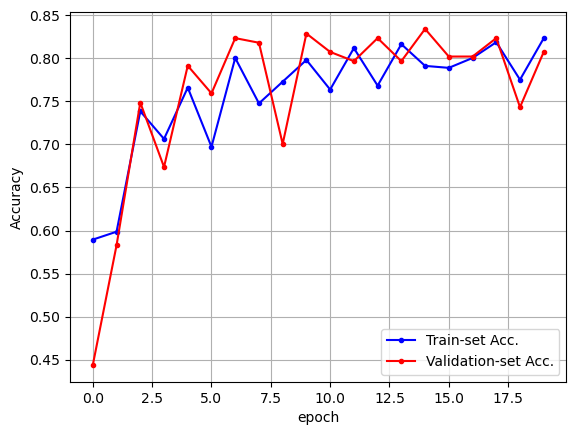

In [25]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

x_len = np.arange(len(acc)) # array of range

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='lower right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

In [39]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

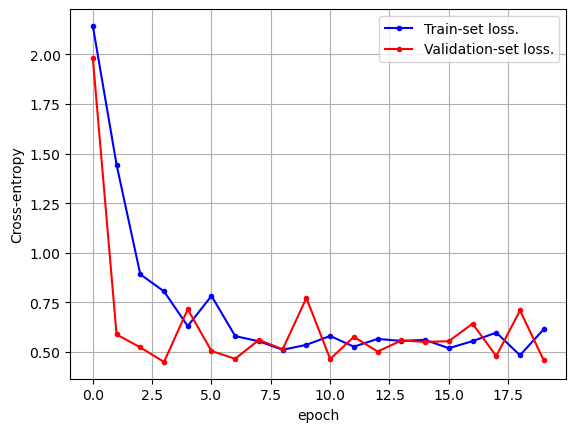

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

In [33]:
test_data.head(3)

,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,isAlone
495,3,0,1.0,0.0,2,3,0.0,1
648,3,0,1.0,0.0,0,3,0.0,1
278,3,0,0.0,0.0,1,1,2.0,0


In [26]:
# 'Predict' on test data

# output layer의 출력
model.predict(test_data) 
# class 0일 확률값과 1일 확률값 (따라서 한 행을 합쳤을 때 그 값이 1이 됨)

array([[9.11593497e-01, 8.84065256e-02],
       [8.93760383e-01, 1.06239557e-01],
       [9.86705840e-01, 1.32941632e-02],
       [1.12314231e-03, 9.98876870e-01],
       [3.53452712e-01, 6.46547258e-01],
       [9.03464675e-01, 9.65352952e-02],
       [3.05479206e-03, 9.96945202e-01],
       [1.20081771e-02, 9.87991869e-01],
       [6.73485518e-01, 3.26514572e-01],
       [4.57728267e-01, 5.42271793e-01],
       [9.72098351e-01, 2.79016346e-02],
       [1.80625930e-01, 8.19374144e-01],
       [8.96682858e-01, 1.03317119e-01],
       [5.91172874e-02, 9.40882683e-01],
       [6.21526386e-04, 9.99378443e-01],
       [1.12628445e-01, 8.87371540e-01],
       [8.93760383e-01, 1.06239557e-01],
       [9.86123204e-01, 1.38768163e-02],
       [9.59883809e-01, 4.01162356e-02],
       [1.20992146e-01, 8.79007876e-01],
       [9.15392041e-01, 8.46079662e-02],
       [6.25473587e-03, 9.93745208e-01],
       [8.96682858e-01, 1.03317119e-01],
       [9.03464675e-01, 9.65352952e-02],
       [4.569147

In [42]:
# 예측이 끝난 행에서 큰 값에 해당하는 인덱스 값 출력 (class 0 OR 1인지 명확하게 판단 가능)
np.argmax(model.predict(test_data), axis=1)  # axis=1 -> 행 방향 

array([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0], dtype=int64)

In [27]:
sample_data = np.array([[3, 0, 0.0, 0.0, 1, 1, 2.0, 0]])

In [28]:
model.predict(sample_data)

array([[0.98670584, 0.01329415]], dtype=float32)

In [29]:
np.argmax(model.predict(sample_data), axis=1)

array([0], dtype=int64)

In [ ]:
end of file